# Problem 1.3 (Microtubule catastrophes I, 50 pts)


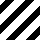
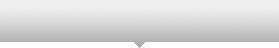
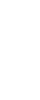
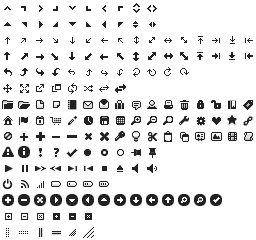
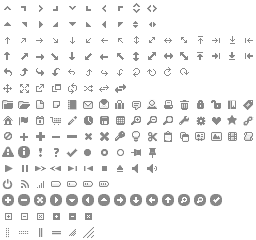
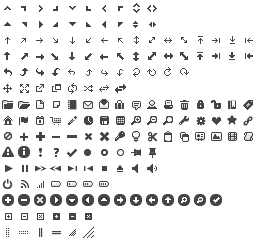
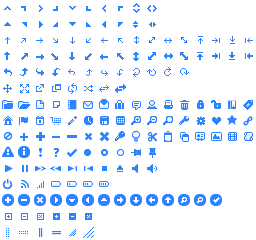
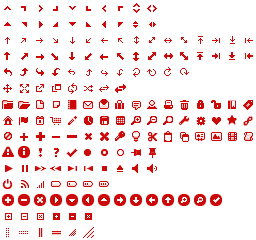
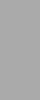
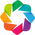
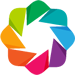
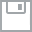
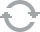
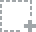
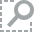
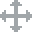
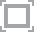
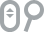

In [229]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.integrate

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Seaborn, useful for graphics
import seaborn as sns

# Import Bokeh modules for interactive plotting
import bokeh.io
import bokeh.mpl
import bokeh.plotting

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline.  There is a bug, so uncomment if it works.
# %config InlineBackend.figure_formats = {'svg',}

# This enables high resolution PNGs. SVG is preferred, but has problems
# rendering vertical and horizontal lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 10, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Set up Bokeh for inline viewing
bokeh.io.output_notebook()

## Exercise 1.3a: Load data

In [198]:
# start by loading the data
df = pd.read_csv('data/gardner_et_al_2011_time_to_catastrophe_dic.csv',comment='#')
df.columns = ['labeled', 'unlabeled']

In [199]:
# Inspect data
df

,labeled,unlabeled
0,470,355
1,1415,425
2,130,540
3,280,265
4,550,1815
5,65,160
6,330,370
7,325,460
8,340,190
9,95,130


Note from Chigozie: I don't think the cell below is a good idea, so I've commented it out pending further discussion.
Inspecting the data, what "rows with incomplete data" means is just that they did more experiments with labeled tubulin than unlabeled tubulin. The data for labeled tubulin is still useful to us, even though it is not paired with an unlabeled tubulin measurement (after all, the pairing doesn't mean anything). Therefore we should tidy the data first, before doing dropna


In [200]:
# Drop the rows with incomplete data
# df.dropna(inplace=True)
# df.columns = ['labeled', 'unlabeled']

## Exercise 1.3b: Tidy data

"I would argue that these data are not tidy. Why?" - Justin Bois  
Each observation should be given a separate row. This is especially true in this case, where the data structure implies that the labeled and unlabeled tubulin measurements are paired in some way, but in fact they are just two separate observations.

We should create a table with columns:

Labeled? | Time (s)

This is easy (even without pd.melt), we can pull out column 'labeled' and add it to our new tidy df (with value True for "Labeled?") and then do the same for column 'unlabeled' (with value False for 'Labeled?'.

In [42]:
# Initialise df with labeled observations
df_tidy = pd.DataFrame({'labeled': True, 'time': df['labeled']})

# Add unlabeled observations
df_tidy = df_tidy.append(pd.DataFrame({'labeled': False, 'time': df['unlabeled']}))

# Drop rows with NaN
df_tidy = df_tidy.dropna()

df_tidy['time']

0      470
1     1415
2      130
3      280
4      550
5       65
6      330
7      325
8      340
9       95
10      55
11     360
12     220
13     225
14     320
15      60
16     210
17     155
18     875
19    1000
20     475
21     295
22     245
23     415
24     305
25     320
26     370
27     505
28    1180
29     440
      ... 
65     160
66     170
67     700
68     695
69     415
70     305
71     145
72     350
73     640
74     165
75     370
76     525
77     950
78     125
79    1255
80     155
81     735
82     215
83     195
84     660
85      80
86     235
87     500
88    1145
89     540
90     180
91     145
92     745
93     390
94    1410
Name: time, dtype: float64

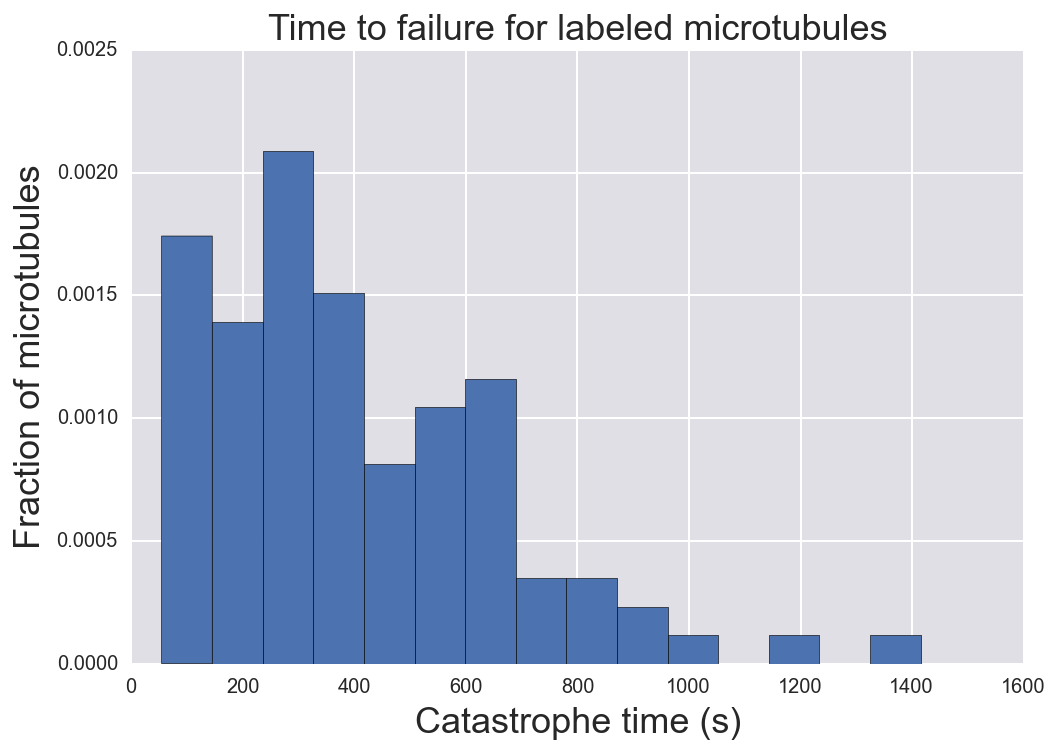

In [43]:
# Make a histogram for the labeled microtubules
# df_tidy['labeled'] happens to already give the list we want, but for clarity here
# we are explicitly making a list of the indices of observations where labeled == True
labeled_inds = (df_tidy['labeled'] == True)

# Plot
_ = plt.hist(df_tidy[labeled_inds]['time'], bins=15, normed=True)
plt.xlabel('Catastrophe time (s)')
plt.ylabel('Fraction of microtubules')
plt.title('Time to failure for labeled microtubules')

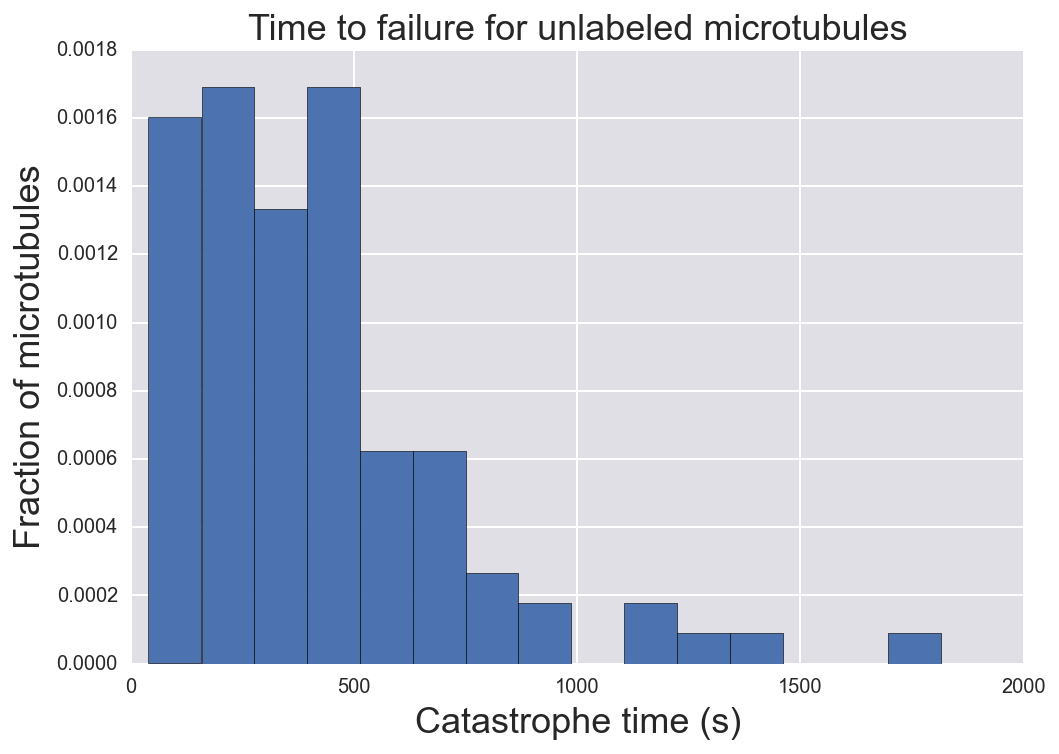

In [94]:
# make a histogram for the unlabeled microtubules
unlabeled_inds = (df_tidy['labeled'] == False)
# Plot
_ = plt.hist(df_tidy[unlabeled_inds]['time'], bins=15, normed=True)
plt.xlabel('Catastrophe time (s)')
plt.ylabel('Fraction of microtubules')
plt.title('Time to failure for unlabeled microtubules')

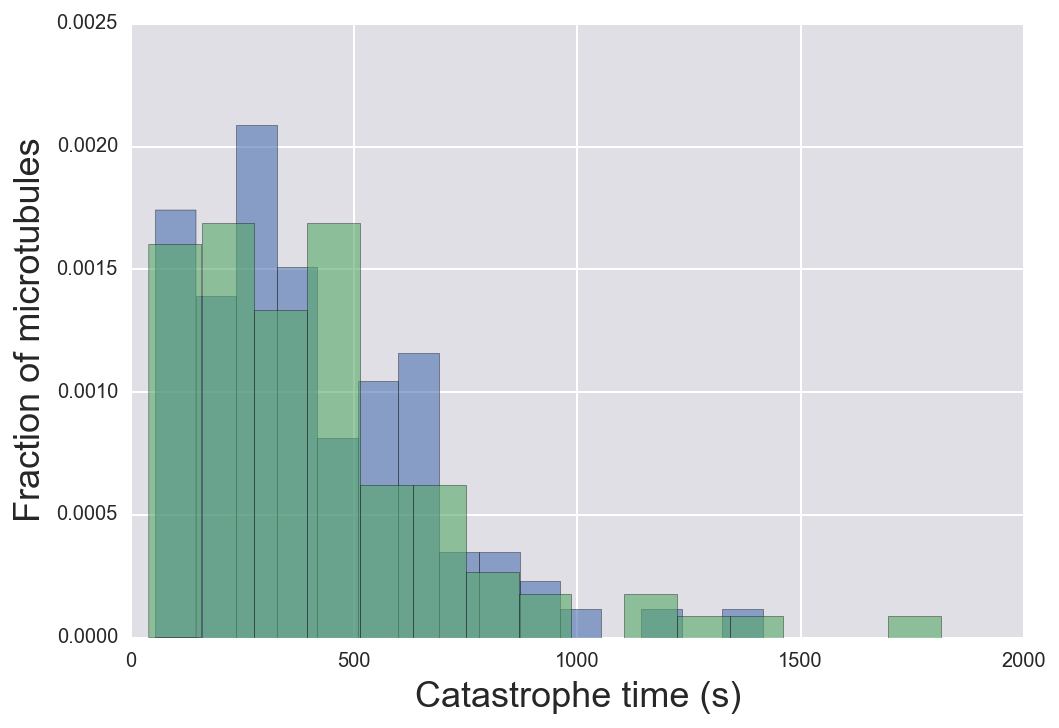

In [47]:
# Nicer to overlay labeled and unlabeled microtubules on same histogram
_ = plt.hist(df_tidy[labeled_inds]['time'], bins=15, normed=True, alpha=0.6)
_ = plt.hist(df_tidy[unlabeled_inds]['time'], bins=15, normed=True, alpha=0.6)

plt.xlabel('Catastrophe time (s)')
plt.ylabel('Fraction of microtubules')

Bins are not the same size because there is a greater range of times in the labeled condition than the unlabeled condition, so it is difficult to compare the data.

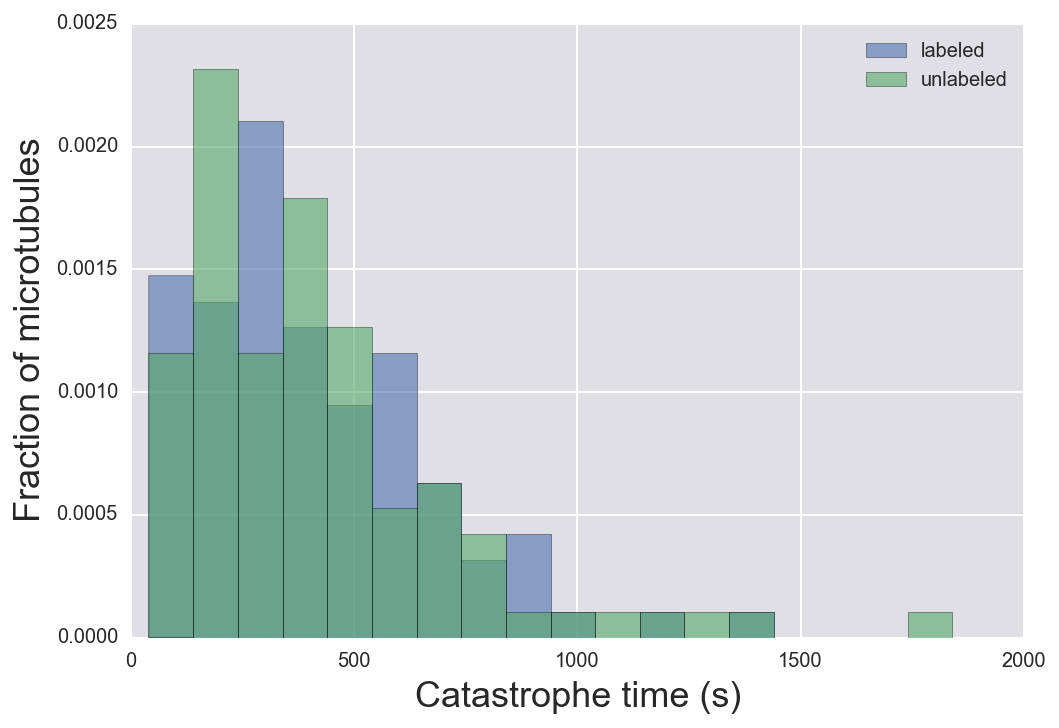

In [51]:
# Use np.arange for equally spaced bins in range of data. The range we use is the whole range,
# including both labeled and unlabeled data, so that both have the same bin size.
# Also, it is clear in this case that we should be normalising, as we are directly comparing
# between labeled and unlabeled microtubules, and we want to answer questions like "do labeled
# microtubules have a longer time before catastrophe?". As there are a different number of
# observations of each type, it is easier if they are scaled so we are looking at fractions of
# observations rather than absolute numbers, with total number of observations of each
# type summing to one. Now we can see that the distributions are similar for labeled/ unlabeled.
_ = plt.hist(df_tidy[labeled_inds]['time'],
         bins=np.arange(min(df_tidy['time']), max(df_tidy['time']) + 100, 100),
         normed=True,
         alpha=0.6)
_ = plt.hist(df_tidy[unlabeled_inds]['time'],
         bins=np.arange(min(df_tidy['time']), max(df_tidy['time']) + 100, 100),
         normed=True,
         alpha=0.6)

plt.xlabel('Catastrophe time (s)')
plt.ylabel('Fraction of microtubules')
plt.legend(['labeled','unlabeled'])

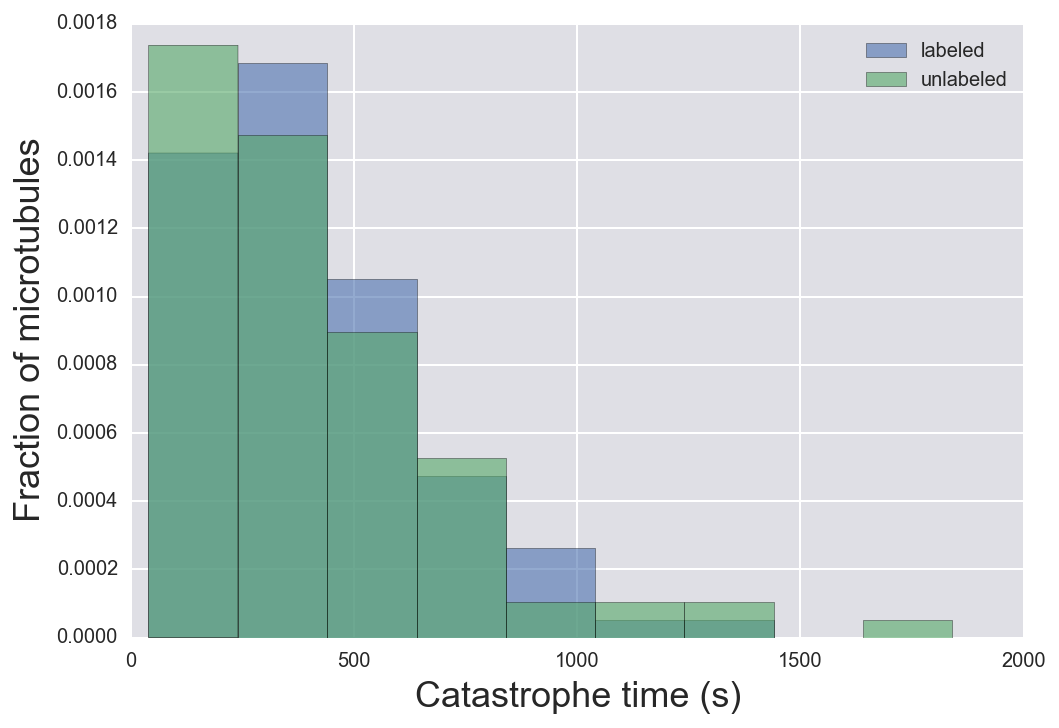

In [96]:
# Try different bin widths. 200 is clearly subject to binning bias, the unlabeled plot
# does not show a maximum but instead decreases monotonically from a catastrophe time of 0-200s on.
_ = plt.hist(df_tidy[labeled_inds]['time'],
         bins=np.arange(min(df_tidy['time']), max(df_tidy['time']) + 200, 200),
         normed=True,
         alpha=0.6)
_ = plt.hist(df_tidy[unlabeled_inds]['time'],
         bins=np.arange(min(df_tidy['time']), max(df_tidy['time']) + 200, 200),
         normed=True,
         alpha=0.6)

plt.xlabel('Catastrophe time (s)')
plt.ylabel('Fraction of microtubules')
plt.legend(['labeled','unlabeled'])

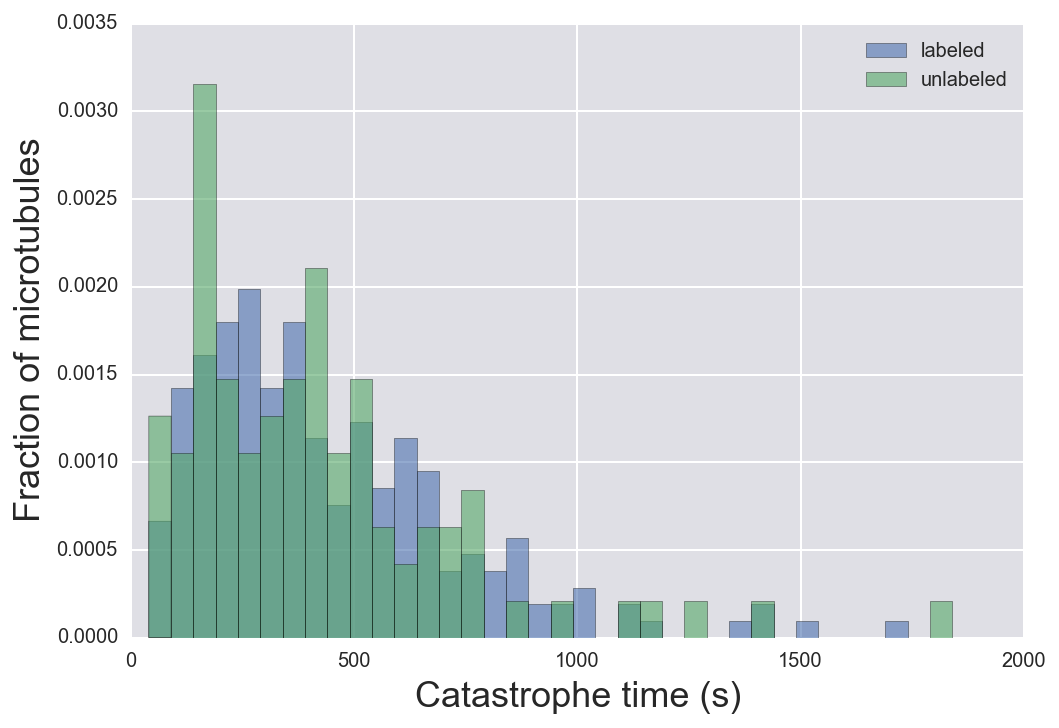

In [238]:
# Try different bin widths. 50 gives more information than 100 but is busier and hard to read.
_ = plt.hist(df_tidy[labeled_inds]['time'],
         bins=np.arange(min(df_tidy['time']), max(df_tidy['time']) + 50, 50),
         normed=True,
         alpha=0.6)
_ = plt.hist(df_tidy[unlabeled_inds]['time'],
         bins=np.arange(min(df_tidy['time']), max(df_tidy['time']) + 50, 50),
         normed=True,
         alpha=0.6)

plt.xlabel('Catastrophe time (s)')
plt.ylabel('Fraction of microtubules')
plt.legend(['labeled','unlabeled'])

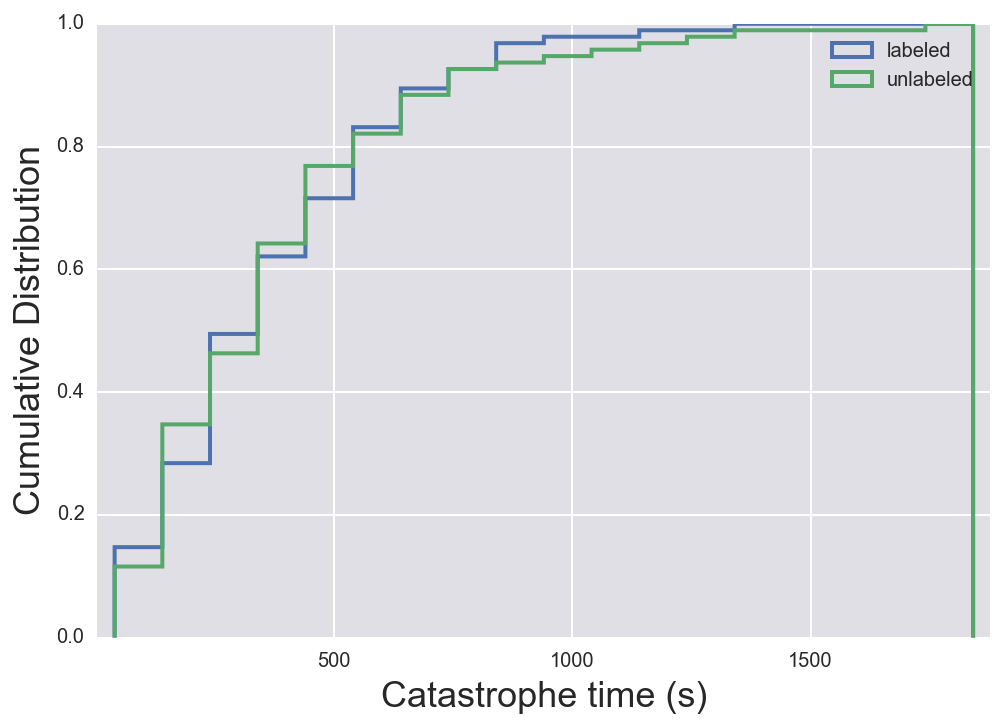

In [55]:
# make a cumulative histogram for the labeled and unlabeled microtubules
_ = plt.hist(df_tidy[labeled_inds]['time'],
         bins=np.arange(min(df_tidy['time']), max(df_tidy['time']) + 100, 100),
         normed=True,
         histtype='step',
         cumulative=True,
         linewidth=2.0)
_ = plt.hist(df_tidy[unlabeled_inds]['time'],
         bins=np.arange(min(df_tidy['time']), max(df_tidy['time']) + 100, 100),
         normed=True,
         histtype='step',
         cumulative=True,
         linewidth=2.0)
plt.xlabel('Catastrophe time (s)')
plt.ylabel('Cumulative Distribution')
plt.legend(['labeled','unlabeled'])
# Doesn't make sense to extend y range beyond 1 for cumulative, normed histogram.
plt.ylim(0,1)
plt.margins(x=0.02, y=0.02)

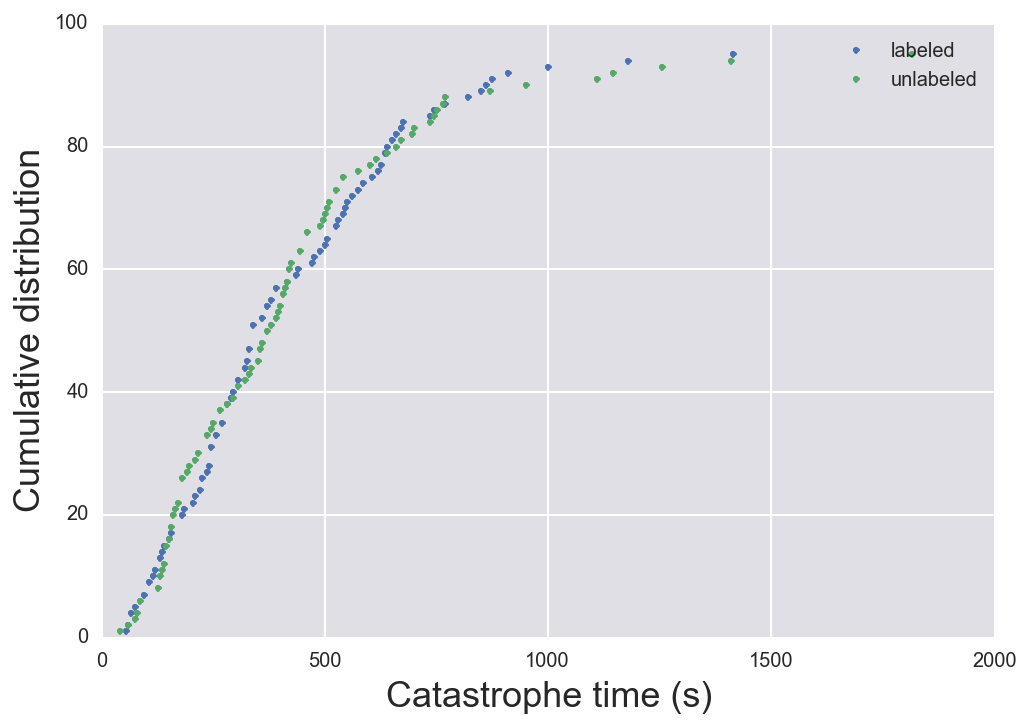

In [105]:
# Make a cumulative histogram for the labeled and unlabeled microtubules with no binning
# Data is rounded to nearest second,
# First, sort the failure times
labeled_times = df_tidy[labeled_inds]['time'][:]
pd.Series.sort(labeled_times,inplace=True)
unlabeled_times = df_tidy[unlabeled_inds]['time'][:]
pd.Series.sort(unlabeled_times,inplace=True)
# then, find the cumulative number at each time
for times in [labeled_times, unlabeled_times]:
    counts = times.value_counts()
    n_failed = []
    n = 0 # cumulative number of failures
    for t in sorted(counts.index):
        n += counts[t]
        n_failed.append(n)
    plt.plot (sorted(counts.index), n_failed,'.')
plt.xlabel('Catastrophe time (s)')
plt.ylabel ('Cumulative distribution')
plt.legend (['labeled','unlabeled'])
        
